## **XGBoost/LightGBM (Time Series Regression)**

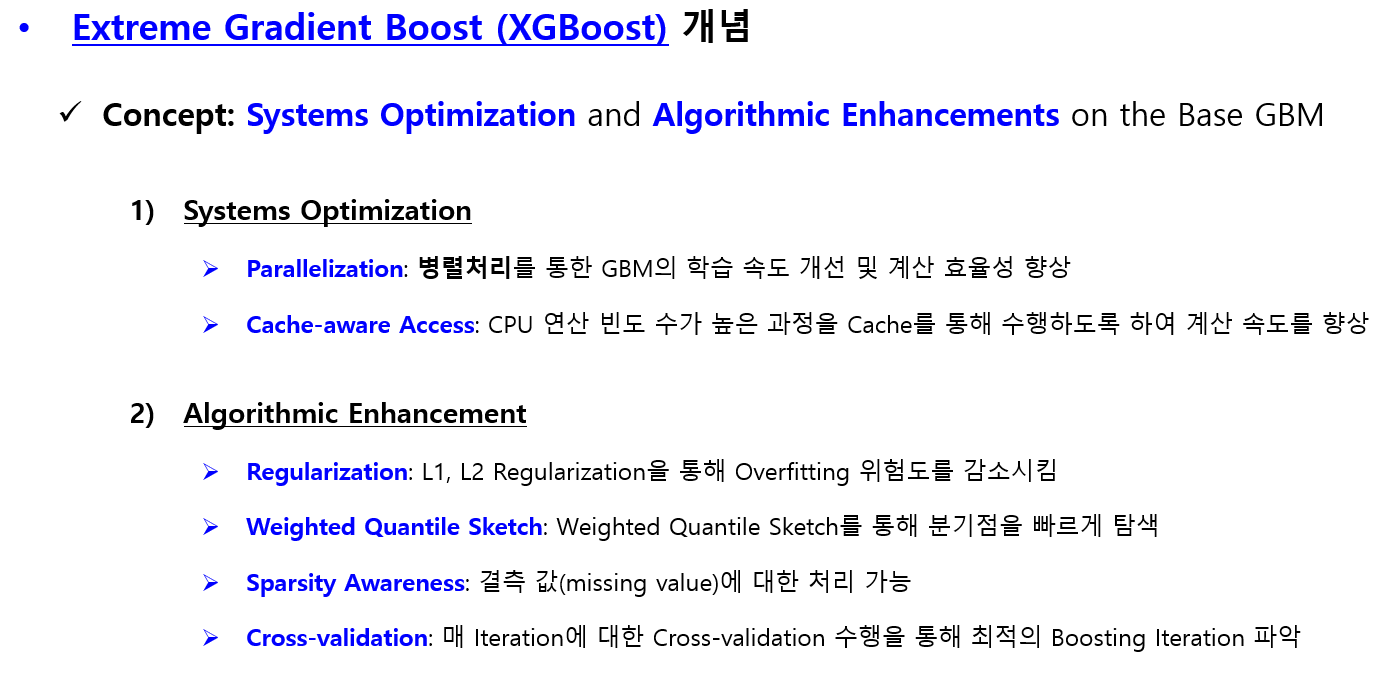

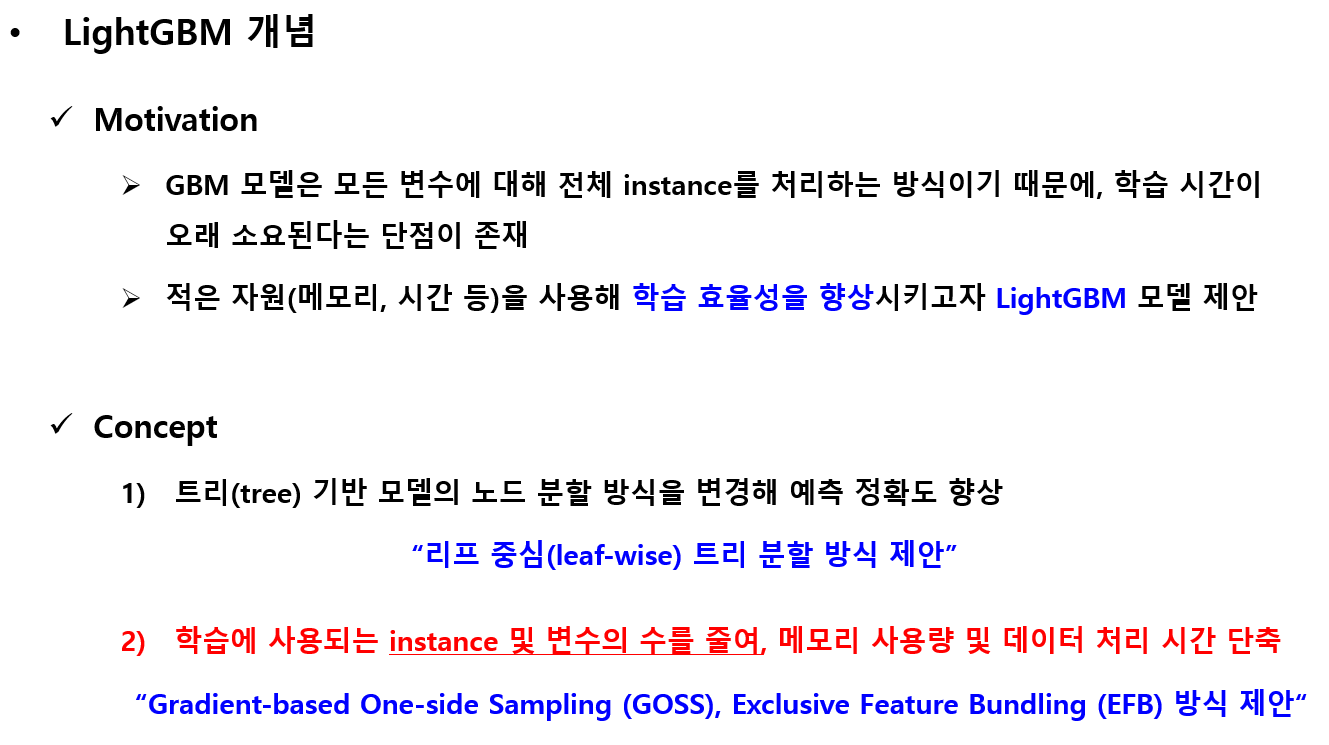

In [1]:
#import library
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import mean_squared_error as mse

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

In [2]:
!git clone https://github.com/yun-seon/LGE_DIC_Training_0308.git

Cloning into 'LGE_DIC_Training_0308'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 16), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (45/45), 9.25 MiB | 6.45 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [3]:
# Data import
df = pd.read_csv("/content/LGE_DIC_Training_0308/AirQuality.csv")
del df['Unnamed: 0']

df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
# 데이터 프레임 shape 확인
print("shape: ", df.shape)

# 데이터 프레임 변수 타입 확인
print("\ntypes:\n", df.dtypes)

# 데이터 프레임 null 확인
print("\nsum of null:\n", df.isnull().sum())

# 데이터 프레임 분위수(통계량) 확인
print("\nquantiles:\n", df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

shape:  (9357, 15)

types:
 Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

sum of null:
 Date                0
Time                0
CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)         8126
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

quantiles:
                    0.00       0.05       0.50        0.95         0.99      1.00
CO(GT)           0.1000    0.50000     1.9000     4.70000     6.700000    11.900
PT08.S1(CO)    647.0000  807.00000  1069.0000  152

- Boxplot

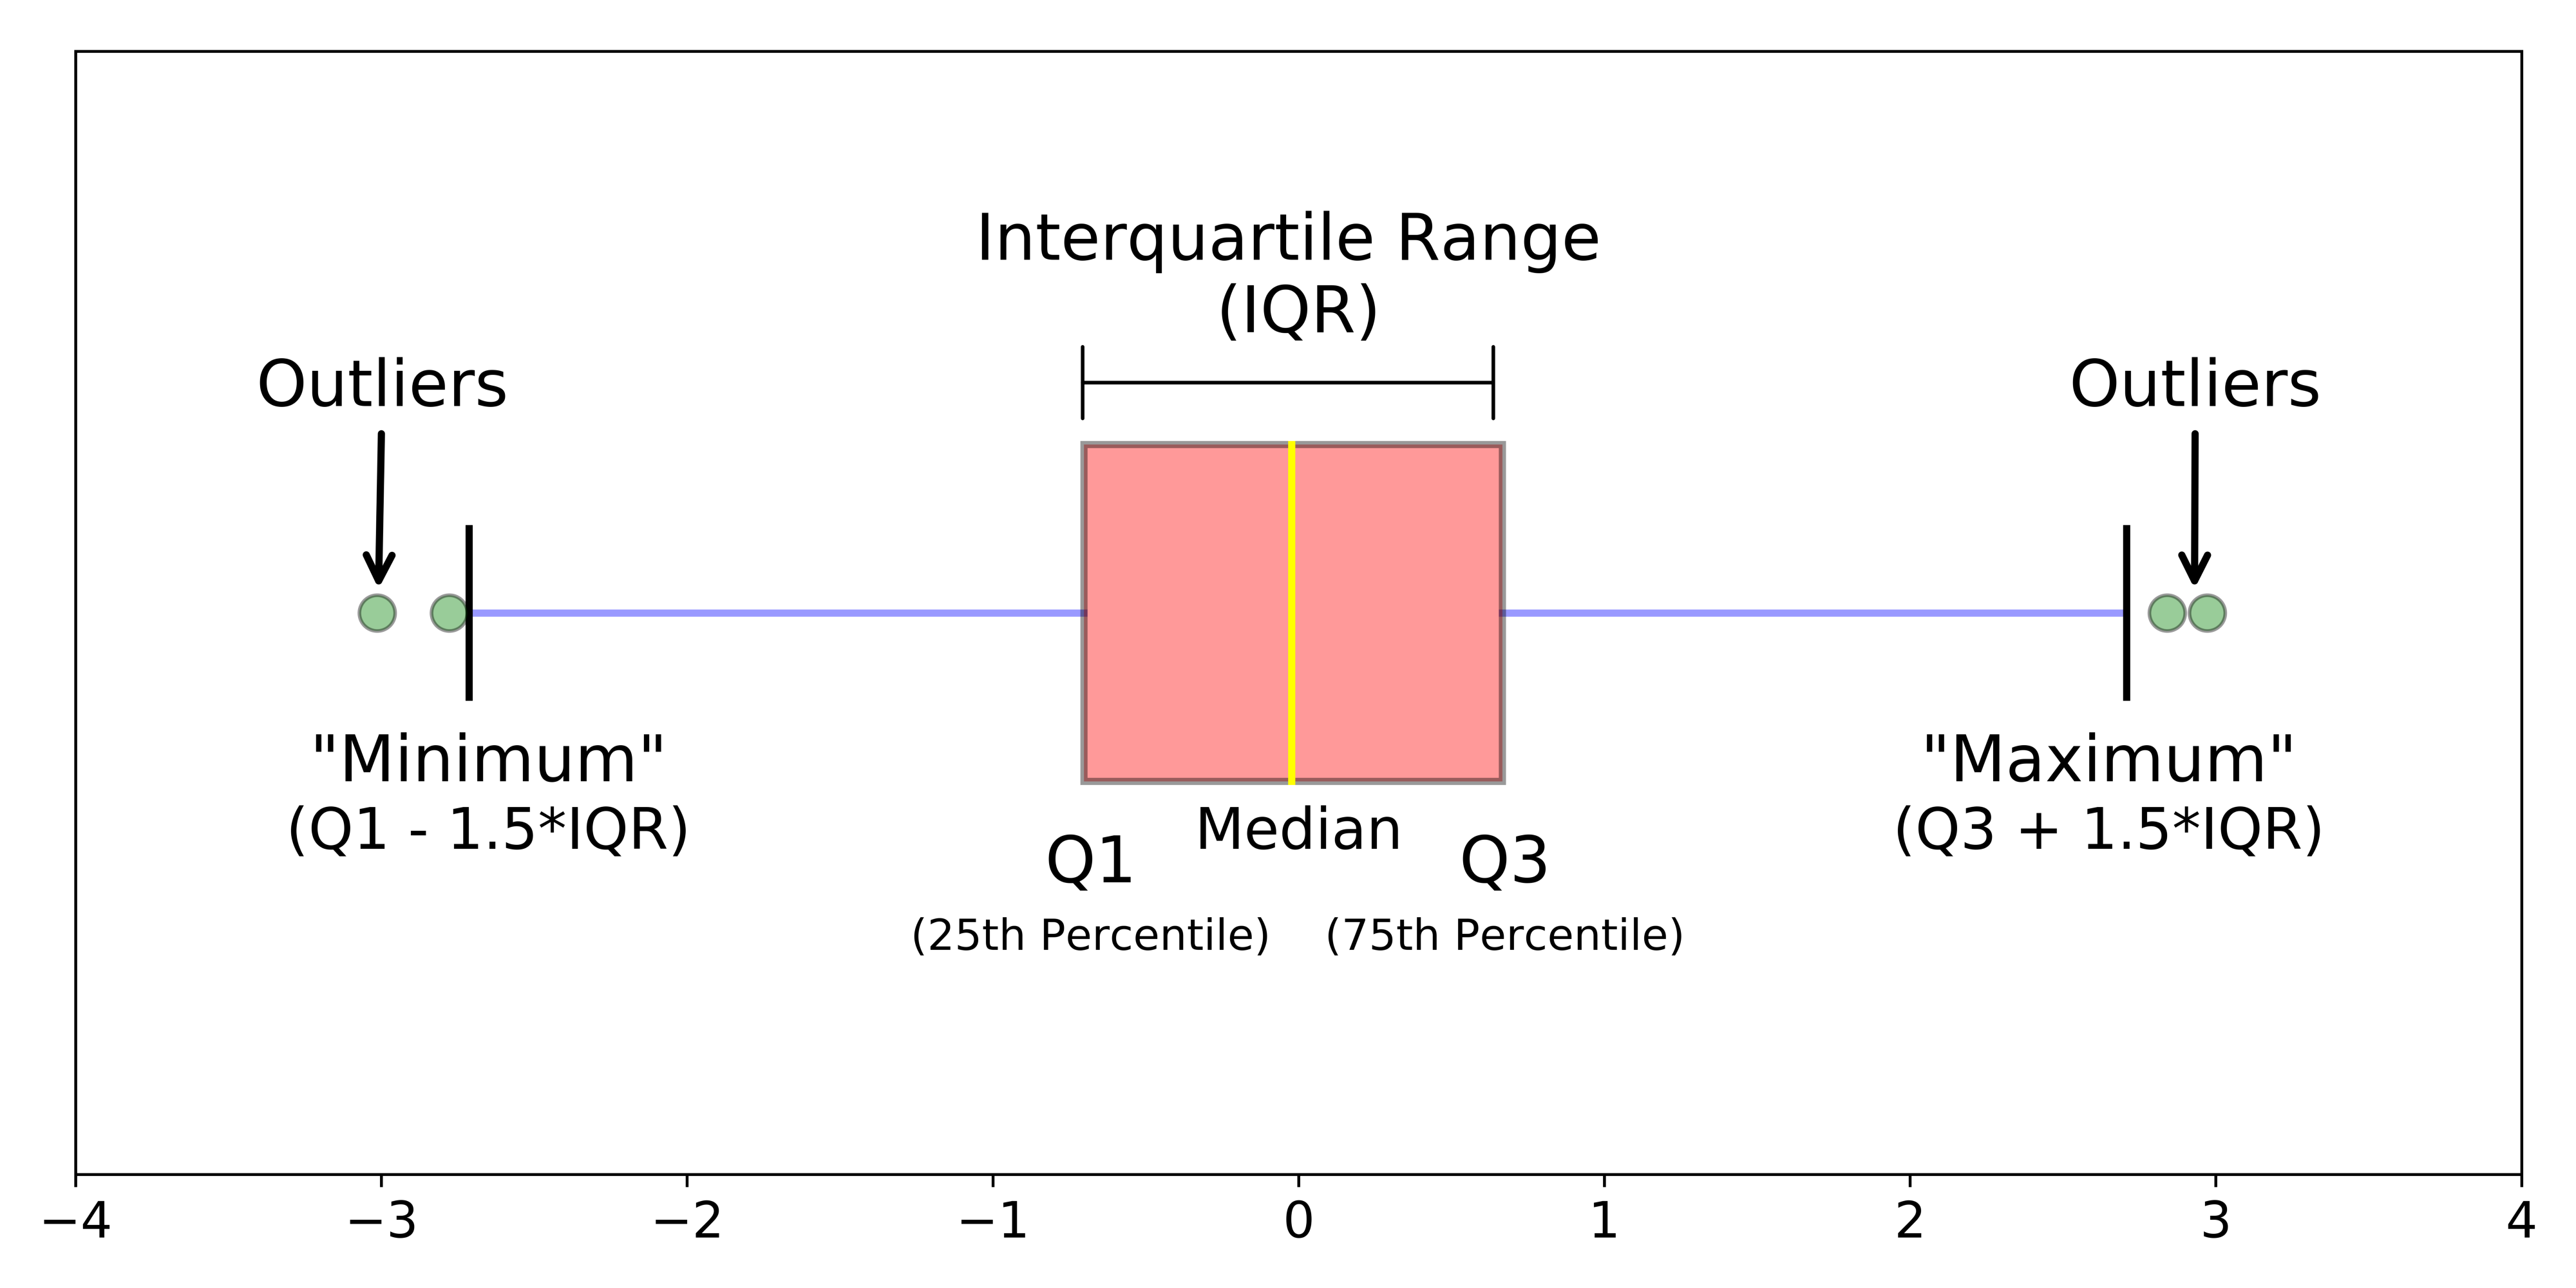

In [5]:
# IQR method 사용: Q1:0.05%, Q3:0.95%
# for outlier check

def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc) # Q1
    quartile3 = dataframe[col_name].quantile(q3_perc) # Q3
    interquantile_range = quartile3 - quartile1       # IQR

    up_limit = quartile3 + 1.5 * interquantile_range  # UCL
    low_limit = quartile1 - 1.5 * interquantile_range # LCL
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):

    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)

    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

check_outlier(df, 'CO(GT)')

False

> Feature Engineering

In [6]:
# select a feature (CO(GT))

name = "CO(GT)"
SIZE = 24

df = df[name]

In [7]:
# for using t0 ~ t23 (24 times)

COLUMNS = ['t{}'.format(x) for x in range(SIZE)] + ['target']
COLUMNS

['t0',
 't1',
 't2',
 't3',
 't4',
 't5',
 't6',
 't7',
 't8',
 't9',
 't10',
 't11',
 't12',
 't13',
 't14',
 't15',
 't16',
 't17',
 't18',
 't19',
 't20',
 't21',
 't22',
 't23',
 'target']

In [8]:
# time series dataframe 구성
time_data = []

for i in range(SIZE, df.shape[0]):
    time_data.append(df.loc[i-SIZE:i].tolist())

time_data = pd.DataFrame(time_data, columns = COLUMNS)
time_data.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t15,t16,t17,t18,t19,t20,t21,t22,t23,target
0,2.6,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,...,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8
1,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,...,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9
2,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,...,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1
3,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,...,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9
4,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,...,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9,1.5


- Shift 함수 (Lag)

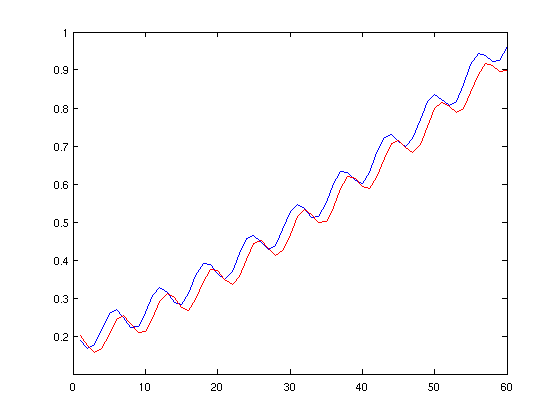

In [9]:
feats_data = pd.DataFrame()
feats_data['prev_1'] = time_data.iloc[:,-2] # Here -2 as -1 is a target

# feature 생성: mean, median, min, max, std, ewma(mean, last), difference, divide

for win in range(3, 27, 3):
    # select columns by recent times
    tmp = time_data.iloc[:,-1-win:-1]
    print("window: ", win)
    print("\ntmp shape:\n", tmp.shape)

    #General statistics for base level
    feats_data['mean_prev_{}'.format(win)] = tmp.mean(axis=1) # mean
    feats_data['median_prev_{}'.format(win)] = tmp.median(axis=1) # median
    feats_data['min_prev_{}'.format(win)] = tmp.min(axis=1) # min
    feats_data['max_prev_{}'.format(win)] = tmp.max(axis=1) # max
    feats_data['std_prev_{}'.format(win)] = tmp.std(axis=1) # standard deviation

    #Capturing trend
    feats_data['mean_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1) # ewm; Exponential Moving Average
    feats_data['last_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1]

    feats_data['avg_diff_{}'.format(win)] = (tmp - tmp.shift(1, axis=1)).mean(axis=1)
    feats_data['avg_div_{}'.format(win)] = (tmp / tmp.shift(1, axis=1)).mean(axis=1)

window:  3

tmp shape:
 (9333, 3)
window:  6

tmp shape:
 (9333, 6)
window:  9

tmp shape:
 (9333, 9)
window:  12

tmp shape:
 (9333, 12)
window:  15

tmp shape:
 (9333, 15)
window:  18

tmp shape:
 (9333, 18)
window:  21

tmp shape:
 (9333, 21)
window:  24

tmp shape:
 (9333, 24)


In [10]:
tmp.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23
0,2.6,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,...,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9
1,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,...,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8
2,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,...,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9
3,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,...,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1
4,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,...,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9


In [11]:
feats_data.head()

,prev_1,mean_prev_3,median_prev_3,min_prev_3,max_prev_3,std_prev_3,mean_ewm_prev_3,last_ewm_prev_3,avg_diff_3,avg_div_3,...,avg_div_21,mean_prev_24,median_prev_24,min_prev_24,max_prev_24,std_prev_24,mean_ewm_prev_24,last_ewm_prev_24,avg_diff_24,avg_div_24
0,2.9,2.433333,2.2,2.2,2.9,0.404145,2.285679,2.457036,0.35,1.159091,...,1.052296,1.658333,1.65,0.6,2.9,0.703356,1.651688,1.868300,0.013043,1.039789
1,4.8,3.300000,2.9,2.2,4.8,1.345362,2.718254,3.387261,1.30,1.486677,...,1.098691,1.750000,1.65,0.6,4.8,0.936227,1.568964,2.168368,0.121739,1.078308
2,6.9,4.866667,4.8,2.9,6.9,2.000833,3.932500,5.000000,2.00,1.546336,...,1.133066,1.954167,1.65,0.6,6.9,1.408354,1.580077,2.665456,0.204348,1.092982
3,6.1,5.933333,6.1,4.8,6.9,1.059874,5.559174,5.975021,0.65,1.160779,...,1.127269,2.116667,1.65,0.6,6.9,1.643344,1.569810,3.029531,0.169565,1.087941
4,3.9,5.633333,6.1,3.9,6.9,1.553491,6.304213,5.532639,-1.50,0.761701,...,1.117569,2.187500,1.65,0.6,6.9,1.683245,1.538297,3.128550,0.100000,1.084118


In [12]:
# 일주일(7일) 간격 특성을 활용하기 위한 feature 생성
for win in [2, 3, 4]:

    tmp = time_data.iloc[:,-1-win*6:-1:6] # row, col, step
    print("window: ", win)
    print("\ntmp shape:\n", tmp.shape)

    #Features for weekly seasonality
    feats_data['6days_mean_prev_{}'.format(win)] = tmp.mean(axis=1)
    feats_data['6days_median_prev_{}'.format(win)] = tmp.median(axis=1)
    feats_data['6days_min_prev_{}'.format(win)] = tmp.min(axis=1)
    feats_data['6days_max_prev_{}'.format(win)] = tmp.max(axis=1)
    feats_data['6days_std_prev_{}'.format(win)] = tmp.std(axis=1)

feats_data = pd.concat([feats_data, time_data.iloc[:, -1]], axis = 1)

window:  2

tmp shape:
 (9333, 2)
window:  3

tmp shape:
 (9333, 3)
window:  4

tmp shape:
 (9333, 4)


In [13]:
tmp.head()

,t0,t6,t12,t18
0,2.6,1.2,0.7,1.6
1,2.0,1.0,1.1,1.9
2,2.2,0.9,2.0,2.9
3,2.2,0.6,2.2,2.2
4,1.6,0.7,1.7,2.2


In [14]:
feats_data.head()

,prev_1,mean_prev_3,median_prev_3,min_prev_3,max_prev_3,std_prev_3,mean_ewm_prev_3,last_ewm_prev_3,avg_diff_3,avg_div_3,...,6days_median_prev_3,6days_min_prev_3,6days_max_prev_3,6days_std_prev_3,6days_mean_prev_4,6days_median_prev_4,6days_min_prev_4,6days_max_prev_4,6days_std_prev_4,target
0,2.9,2.433333,2.2,2.2,2.9,0.404145,2.285679,2.457036,0.35,1.159091,...,1.2,0.7,1.6,0.450925,1.525,1.40,0.7,2.6,0.805709,4.8
1,4.8,3.300000,2.9,2.2,4.8,1.345362,2.718254,3.387261,1.30,1.486677,...,1.1,1.0,1.9,0.493288,1.500,1.50,1.0,2.0,0.522813,6.9
2,6.9,4.866667,4.8,2.9,6.9,2.000833,3.932500,5.000000,2.00,1.546336,...,2.0,0.9,2.9,1.001665,2.000,2.10,0.9,2.9,0.828654,6.1
3,6.1,5.933333,6.1,4.8,6.9,1.059874,5.559174,5.975021,0.65,1.160779,...,2.2,0.6,2.2,0.923760,1.800,2.20,0.6,2.2,0.800000,3.9
4,3.9,5.633333,6.1,3.9,6.9,1.553491,6.304213,5.532639,-1.50,0.761701,...,1.7,0.7,2.2,0.763763,1.550,1.65,0.7,2.2,0.624500,1.5


In [15]:
# split train and test data
train_data      = feats_data.iloc[0:8000, :]
validation_data = feats_data.iloc[8000:9000, :] # 제거
test_data       = feats_data.iloc[9000:, :]

X_train = train_data.iloc[:, :-1]; Y_train = train_data.iloc[:, -1]
X_test  = test_data.iloc[:, :-1];  Y_test  = test_data.iloc[:, -1]

## Model 1. XGBoost

In [16]:
from xgboost import XGBRegressor

'''
Parameter 참고: https://xgboost.readthedocs.io/en/stable/parameter.html
'''

model_XG = XGBRegressor(learning_rate    = 0.3,
                        max_depth        = 6)

model_XG.fit(X_train, Y_train, eval_metric="error", early_stopping_rounds = 10, eval_set=[(X_test, Y_test)], verbose=True)

[0]	validation_0-error:-0.86547
[1]	validation_0-error:-0.86547
[2]	validation_0-error:-0.86547
[3]	validation_0-error:-0.86547
[4]	validation_0-error:-0.86547
[5]	validation_0-error:-0.86547
[6]	validation_0-error:-0.86186
[7]	validation_0-error:-0.86246
[8]	validation_0-error:-0.86246
[9]	validation_0-error:-0.86246
[10]	validation_0-error:-0.86246


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

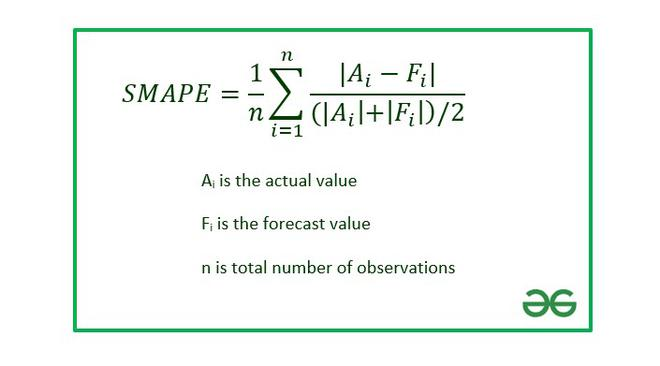

In [17]:
# SMAPE (Symmetric Mean Absolute Percentage Error) 평가지표 사용

def smape(preds, target):

    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def val_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [18]:
# testset의 Sales 값 예측 (log value)
pred_XG = model_XG.predict(X_test)

# 평가지표
print("SMPE : ", smape(np.expm1(pred_XG), np.expm1(Y_test)))
print("R-squared: ", model_XG.score(X_train, Y_train))

SMPE :  89.52007135828005
R-squared:  0.4202984132320611


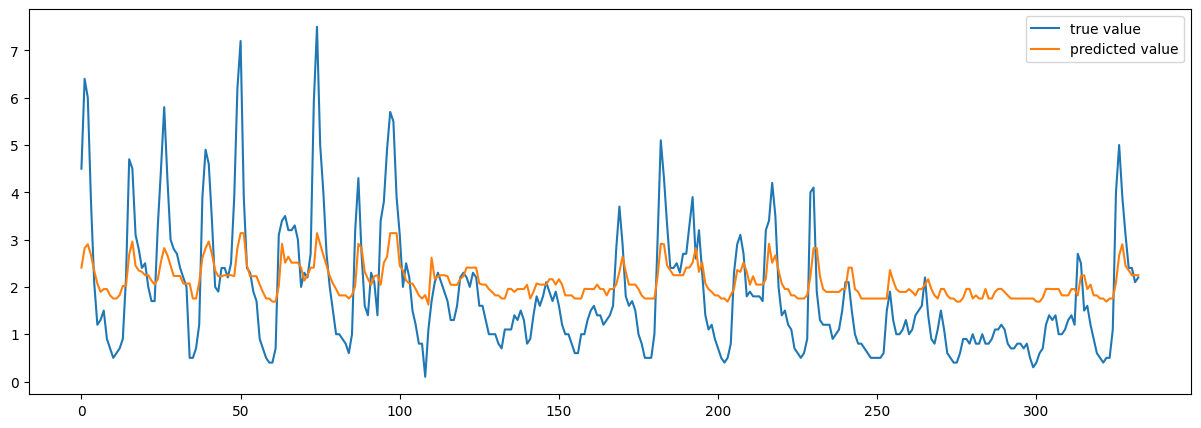

In [19]:
# 예측 값과 실제 값 비교
plt.figure(figsize = (15, 5))
plt.plot(Y_test.values, label = 'true value')
plt.plot(pred_XG, label = 'predicted value')
plt.legend()
plt.show()

## Model 2. LightGBM

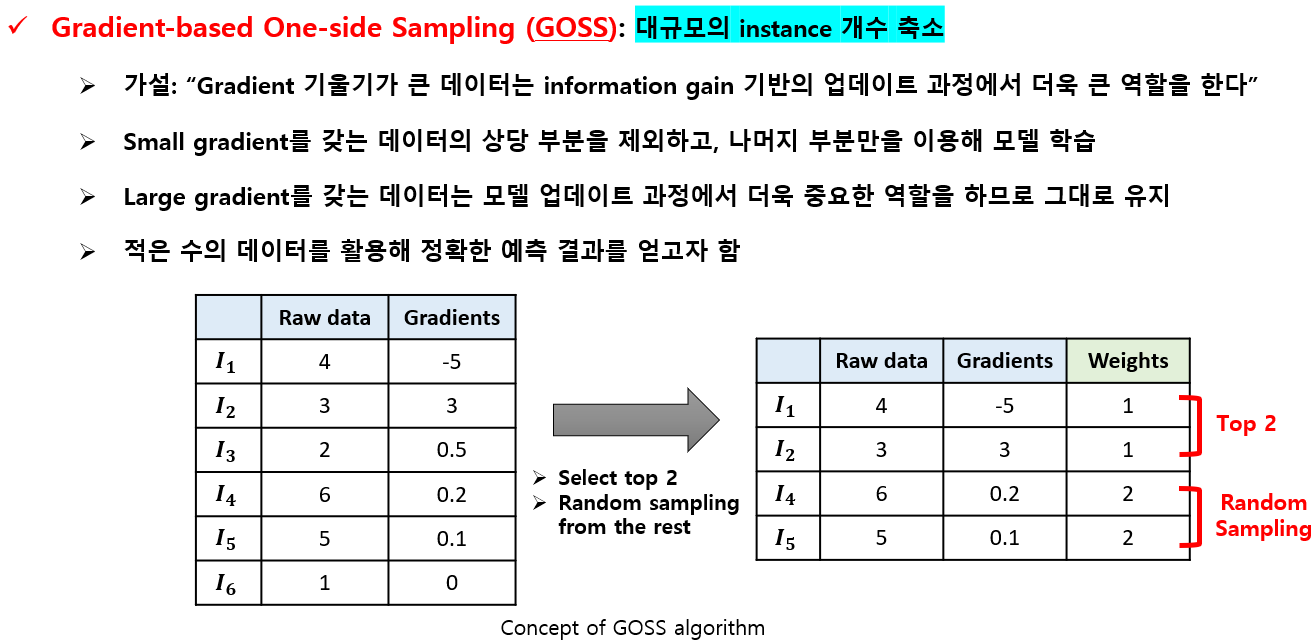

In [32]:
from lightgbm import LGBMRegressor
'''
Parameter 참고: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

boosting type:
    'gbdt' (traditional Gradient Boosting Decision Tree), 'dart' (Multiple Additive Regression Trees), 'goss' (Gradient-based One-side Sampling), 'rf' (Random Forest)
'''
model_LGBM = LGBMRegressor(learning_rate    = 0.01,
                           boosting_type    = 'goss',
                           feature_fraction = 0.5,
                           max_depth        = 10,
                           verbose          = 0,
                           num_boost_rounds = 15000)

model_LGBM.fit(X_train, Y_train, eval_metric="error", eval_set=[(X_test, Y_test)])

[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this 

LGBMRegressor(boosting_type='goss', feature_fraction=0.5, learning_rate=0.01,
              max_depth=10, num_boost_rounds=15000, verbose=0)

In [33]:
# testset의 Sales 값 예측 (log value)
pred_LGBM = model_LGBM.predict(X_test)

# 평가지표
print("SMPE : ", smape(np.expm1(pred_LGBM), np.expm1(Y_test)))
print("R-squared: ", model_LGBM.score(X_train, Y_train))

[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
SMPE :  67.40096394258408
[LightGBM] [Warning] Unknown parameter: num_boost_rounds
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strat

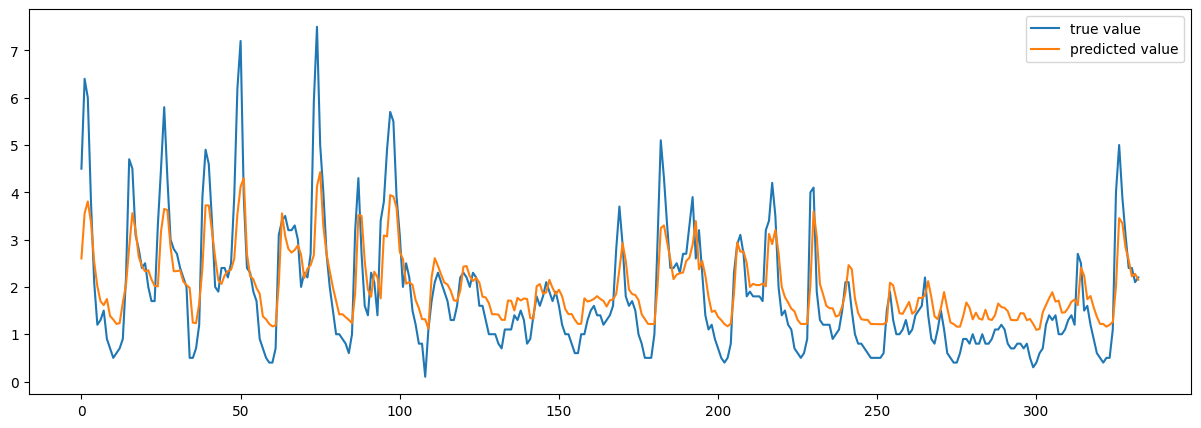

In [34]:
# 예측 값과 실제 값 비교
plt.figure(figsize = (15, 5))
plt.plot(Y_test.values, label = 'true value')
plt.plot(pred_LGBM, label = 'predicted value')
plt.legend()
plt.show()

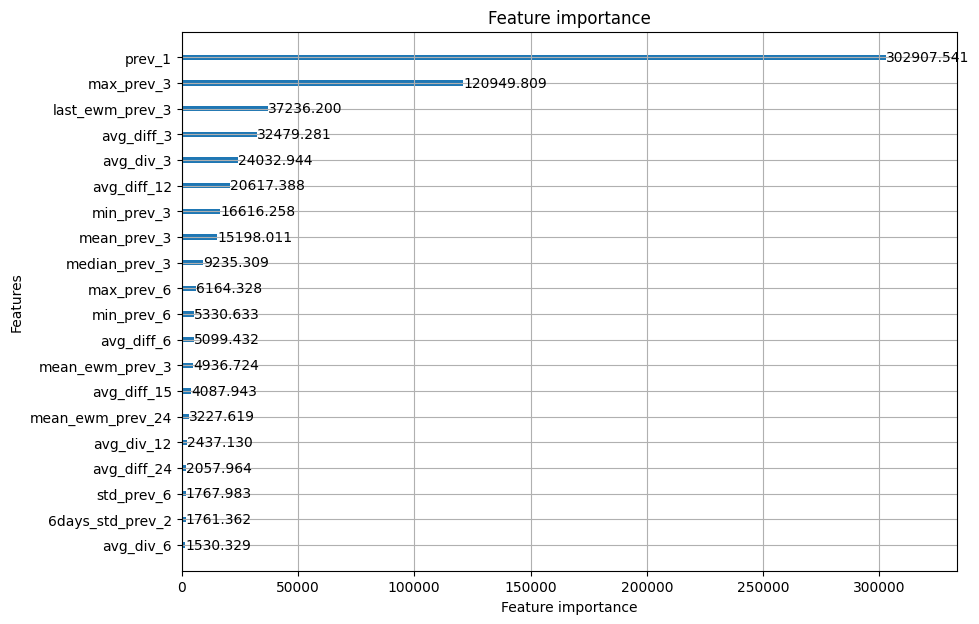

In [35]:
# 변수중요도 계산

lgb.plot_importance(model_LGBM, max_num_features=20, figsize=(10, 7), importance_type="gain")
plt.show()